In [1]:
import os
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


label_dict = {"houses": 0, "lions": 1,"pandas": 2, "tigers": 3}
class_dict = {0: "houses", 1: "lions", 2: "pandas", 3: "tigers"}
N = 4

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    def __len__(self):
        return len(self.data)


def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader




In [26]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [27]:
train()

data processing...
train...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|##7                                                                                | 1/30 [00:17<08:21, 17.28s/it]

Epoch 000 train_loss 1.20291 val_loss 1.24707


  7%|#####5                                                                             | 2/30 [00:28<06:19, 13.55s/it]

Epoch 001 train_loss 0.96150 val_loss 0.95996


 10%|########3                                                                          | 3/30 [00:39<05:38, 12.55s/it]

Epoch 002 train_loss 0.92855 val_loss 1.01369


 13%|###########                                                                        | 4/30 [00:51<05:14, 12.11s/it]

Epoch 003 train_loss 0.92196 val_loss 0.93655


 17%|#############8                                                                     | 5/30 [01:02<04:57, 11.91s/it]

Epoch 004 train_loss 0.89936 val_loss 0.94779


 20%|################6                                                                  | 6/30 [01:14<04:45, 11.90s/it]

Epoch 005 train_loss 0.90151 val_loss 0.93219


 23%|###################3                                                               | 7/30 [01:25<04:29, 11.73s/it]

Epoch 006 train_loss 0.87159 val_loss 0.89994


 27%|######################1                                                            | 8/30 [01:37<04:19, 11.77s/it]

Epoch 007 train_loss 0.87822 val_loss 0.93442


 30%|########################9                                                          | 9/30 [01:48<04:03, 11.59s/it]

Epoch 008 train_loss 0.87278 val_loss 0.93976


 33%|###########################3                                                      | 10/30 [02:00<03:49, 11.47s/it]

Epoch 009 train_loss 0.86530 val_loss 0.94330


 37%|##############################                                                    | 11/30 [02:11<03:37, 11.46s/it]

Epoch 010 train_loss 0.87463 val_loss 0.91618


 40%|################################8                                                 | 12/30 [02:22<03:24, 11.36s/it]

Epoch 011 train_loss 0.87613 val_loss 0.96065


 43%|###################################5                                              | 13/30 [02:33<03:12, 11.35s/it]

Epoch 012 train_loss 0.84671 val_loss 0.90393


 47%|######################################2                                           | 14/30 [02:45<03:00, 11.31s/it]

Epoch 013 train_loss 0.84717 val_loss 0.88864


 50%|#########################################                                         | 15/30 [02:56<02:51, 11.41s/it]

Epoch 014 train_loss 0.83875 val_loss 0.89406


 53%|###########################################7                                      | 16/30 [03:08<02:39, 11.43s/it]

Epoch 015 train_loss 0.84442 val_loss 0.88603


 57%|##############################################4                                   | 17/30 [03:19<02:29, 11.48s/it]

Epoch 016 train_loss 0.84052 val_loss 0.99051


 60%|#################################################1                                | 18/30 [03:31<02:17, 11.46s/it]

Epoch 017 train_loss 0.83846 val_loss 0.87875


 63%|###################################################9                              | 19/30 [03:42<02:05, 11.43s/it]

Epoch 018 train_loss 0.83107 val_loss 0.92023


 67%|######################################################6                           | 20/30 [03:54<01:55, 11.52s/it]

Epoch 019 train_loss 0.84622 val_loss 0.91327


 70%|#########################################################4                        | 21/30 [04:05<01:42, 11.44s/it]

Epoch 020 train_loss 0.84317 val_loss 0.94451


 73%|############################################################1                     | 22/30 [04:17<01:31, 11.45s/it]

Epoch 021 train_loss 0.83914 val_loss 0.90298


 77%|##############################################################8                   | 23/30 [04:28<01:19, 11.43s/it]

Epoch 022 train_loss 0.84591 val_loss 0.89365


 80%|#################################################################6                | 24/30 [04:40<01:08, 11.45s/it]

Epoch 023 train_loss 0.84427 val_loss 0.89843


 83%|####################################################################3             | 25/30 [04:51<00:57, 11.42s/it]

Epoch 024 train_loss 0.84179 val_loss 0.94917


 87%|#######################################################################           | 26/30 [05:02<00:45, 11.45s/it]

Epoch 025 train_loss 0.83536 val_loss 0.90292


 90%|#########################################################################8        | 27/30 [05:14<00:34, 11.48s/it]

Epoch 026 train_loss 0.83026 val_loss 0.88012


 93%|############################################################################5     | 28/30 [05:25<00:22, 11.42s/it]

Epoch 027 train_loss 0.83446 val_loss 0.90765


 97%|###############################################################################2  | 29/30 [05:37<00:11, 11.53s/it]

Epoch 028 train_loss 0.81957 val_loss 0.90424


100%|##################################################################################| 30/30 [05:48<00:00, 11.63s/it]


Epoch 029 train_loss 0.83051 val_loss 0.87775


2024-11-22 11:44:27.370 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 365.4340121746063 s


In [28]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [29]:
test()

data processing...


C:\Users\admin\AppData\Local\Temp/ipykernel_12584/1345067293.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


Accuracy:91%


In [30]:
pip install tensorboard loguru -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simpleNote: you may need to restart the kernel to use updated packages.



# 测试动物分类模型

In [31]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [32]:
import unittest
from PIL import Image

import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/houses/01_015.png"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
output

C:\Users\admin\AppData\Local\Temp/ipykernel_12584/3613255345.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


tensor([[-0.7438, -1.7435, -1.7436, -1.7436]], grad_fn=<LogSoftmaxBackward0>)

In [33]:
np.log(0.5)

-0.6931471805599453

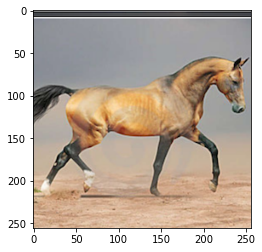

In [34]:
plt.imshow(img, cmap='gray')
plt.show()

In [35]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

houses


In [37]:
import torch
torch.__version__

'2.5.1+cpu'